In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image

# Set paths
train_dir = '/content/drive/MyDrive/UCSDped2/Train'
test_dir = '/content/drive/MyDrive/UCSDped2/Test'

# Parameters
image_size = (126, 126)
batch_size = 256
num_classes = 2  # Normal (0) and Anomaly (1)

In [ ]:
import os

# Function to list, count folders, and calculate file size
def list_and_count_folders_with_files(directory):
    folder_info = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):  # Check if it's a folder
            file_count = 0
            total_size = 0
            for root, _, files in os.walk(folder_path):
                file_count += len(files)
                total_size += sum(os.path.getsize(os.path.join(root, f)) for f in files)
            folder_info.append((folder_name, file_count, total_size))

    # Print folder information
    print(f"Folders in {directory}:")
    for name, count, size in folder_info:
        print(f"  {name}: {count} files, {size / 1024:.2f} KB")

    return len(folder_info), folder_info

# Print train and test dataset folders with counts and file sizes
train_count, train_info = list_and_count_folders_with_files(train_dir)
print(f"Total Train Folders: {train_count}\n")

test_count, test_info = list_and_count_folders_with_files(test_dir)
print(f"Total Test Folders: {test_count}")


Folders in /content/drive/MyDrive/UCSDped2/Train:
  Train009: 180 files, 14573.26 KB
  Train011: 180 files, 14509.14 KB
  Train013: 180 files, 14524.58 KB
  Train016: 150 files, 12158.21 KB
  Train014: 150 files, 12177.37 KB
  Train007: 150 files, 12091.86 KB
  Train008: 120 files, 9594.77 KB
  Train015: 152 files, 12157.60 KB
  Train010: 180 files, 14522.90 KB
  Train012: 180 files, 14488.99 KB
  Train002: 150 files, 11697.92 KB
  Train004: 180 files, 14635.57 KB
  Train005: 180 files, 14521.49 KB
  Train001: 120 files, 9381.54 KB
  Train003: 150 files, 11578.79 KB
  Train006: 150 files, 12171.98 KB
Total Train Folders: 16

Folders in /content/drive/MyDrive/UCSDped2/Test:
  Test012: 180 files, 14243.87 KB
  Test011_gt: 182 files, 15383.08 KB
  Test011: 182 files, 14134.31 KB
  Test012_gt: 180 files, 15376.99 KB
  Test010: 150 files, 12054.53 KB
  Test009: 122 files, 9514.02 KB
  Test008: 182 files, 14492.75 KB
  Test006_gt: 180 files, 15376.99 KB
  Test008_gt: 182 files, 15383.08 KB
 

In [ ]:
# Preprocessing function
def preprocess_images(directory, image_size):
    images, labels = [], []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        label = 1 if 'anomaly' in folder_name.lower() else 0  # Adjust based on your folder naming convention
        for file_name in os.listdir(folder_path):
            if not file_name.endswith(('.tif', '.png', '.jpg', '.jpeg')):  # Skip non-image files
                continue
            file_path = os.path.join(folder_path, file_name)
            try:
                img = Image.open(file_path).resize(image_size).convert('RGB')
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    return np.array(images), np.array(labels)


# Load and preprocess data
x_train, y_train = preprocess_images(train_dir, image_size)
x_test, y_test = preprocess_images(test_dir, image_size)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

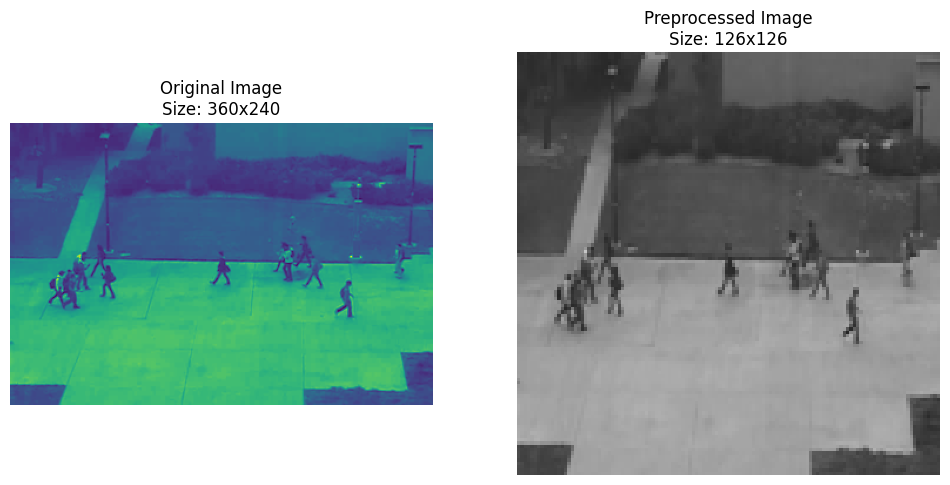

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Display a sample image before and after preprocessing with size annotations
def display_image_samples_with_size(directory, image_size):
    # Get a list of folder names (train or test folder)
    folder_name = os.listdir(directory)[0]  # Just use the first folder for demonstration
    folder_path = os.path.join(directory, folder_name)

    # Get a sample image file from that folder
    sample_image_file = os.listdir(folder_path)[0]
    image_path = os.path.join(folder_path, sample_image_file)

    # Load the image using PIL
    original_image = Image.open(image_path)

    # Preprocess the image (resize and normalize)
    preprocessed_image = original_image.resize(image_size).convert('RGB')
    preprocessed_image = np.array(preprocessed_image) / 255.0

    # Get the size of original and preprocessed images
    original_size = original_image.size  # (width, height)
    preprocessed_size = preprocessed_image.shape  # (height, width, channels)

    # Create the plot with original and preprocessed images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image\nSize: {original_size[0]}x{original_size[1]}")
    axes[0].axis('off')  # Hide axes

    # Preprocessed Image
    axes[1].imshow(preprocessed_image)
    axes[1].set_title(f"Preprocessed Image\nSize: {preprocessed_size[1]}x{preprocessed_size[0]}")
    axes[1].axis('off')  # Hide axes

    # Show the plot
    plt.show()

# Display sample images before and after preprocessing with size info from the training directory
display_image_samples_with_size(train_dir, image_size)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Data augmentation with moderate settings
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced rotation to speed up
    width_shift_range=0.05,  # Reduced shift to speed up
    height_shift_range=0.05,  # Reduced shift to speed up
    horizontal_flip=True,
)
datagen.fit(x_train)

# Create ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Reduced neurons to decrease computation
x = Dropout(0.5)(x)  # Regularization to avoid overfitting
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze more layers for faster training
for layer in base_model.layers[:100]:  # Freeze first 100 layers to reduce computation
    layer.trainable = False

# Compile the model with a moderate learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

# Train the model with fewer epochs for faster results
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    validation_data=(x_test, y_test),
                    epochs=3,  # Train for fewer epochs
                    callbacks=[early_stopping, reduce_lr])

# Unfreeze the remaining layers for fine-tuning
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompile and fine-tune with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 596s 28s/step - accuracy: 0.8687 - loss: 0.2047 - val_accuracy: 0.0000e+00 - val_loss: 1.3401 - learning_rate: 1.0000e-04
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 616s 28s/step - accuracy: 1.0000 - loss: 6.0519e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.1278 - learning_rate: 1.0000e-04
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 559s 28s/step - accuracy: 1.0000 - loss: 4.2273e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.0101 - learning_rate: 1.0000e-04
